In [115]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

In [116]:
df_customers = pd.read_csv("https://dojo-git.s3.eu-west-3.amazonaws.com/cleaned/customers.csv", sep=";")
df_products = pd.read_csv("https://dojo-git.s3.eu-west-3.amazonaws.com/cleaned/products.csv", sep=";")
df_transactions = pd.read_csv("https://dojo-git.s3.eu-west-3.amazonaws.com/cleaned/Transactions.csv", sep=";")

In [117]:
df_customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8616,c_7920,m,1956
8617,c_7403,f,1970
8618,c_5119,m,1974
8619,c_5643,f,1968


In [118]:
df_products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


In [119]:
df_transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848


In [120]:
df_merge1 = pd.merge(df_transactions, df_products, on='id_prod', how='left')

In [121]:
df_merge = pd.merge(df_merge1, df_customers, on='client_id', how='left')

In [122]:
df_merge


,id_prod,date,session_id,client_id,price,categ,sex,birth
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,11.99,0,f,1967
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,19.37,0,m,1960
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,4.50,0,m,1988
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,6.55,0,f,1989
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,16.49,0,f,1956
...,...,...,...,...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,21.92,1,f,1996
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,48.99,2,f,1994
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,26.99,1,f,1985
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,8.99,0,m,1953


In [123]:
df_merge.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
sex           0
birth         0
dtype: int64

# Méthode K-means

In [95]:
today = datetime.now()

In [96]:
df_merge['date'] = pd.to_datetime(df_merge['date'], format='mixed', errors='coerce')


In [97]:
rfm = df_merge.groupby('client_id').agg(
    {
        'date' : lambda x: (today - x.max()).days, # Calcul du nombre de jours entre la date d'aujourd'hui et la date de la dernière commande par clients
        'client_id' : 'count',
        'price' : 'sum',
        }
    ).rename(columns={
            'date' : 'Recency',
            'client_id' : 'Frequency',
            'price' : 'Monetary',
        }
    ).reset_index()

In [98]:
rfm

,client_id,Recency,Frequency,Monetary
0,c_1,499,43,629.02
1,c_10,488,58,1353.60
2,c_100,617,8,254.85
3,c_1000,490,126,2291.88
4,c_1001,460,103,1823.85
...,...,...,...,...
8595,c_995,554,14,189.41
8596,c_996,463,96,1637.34
8597,c_997,479,59,1490.01
8598,c_998,461,55,2822.22


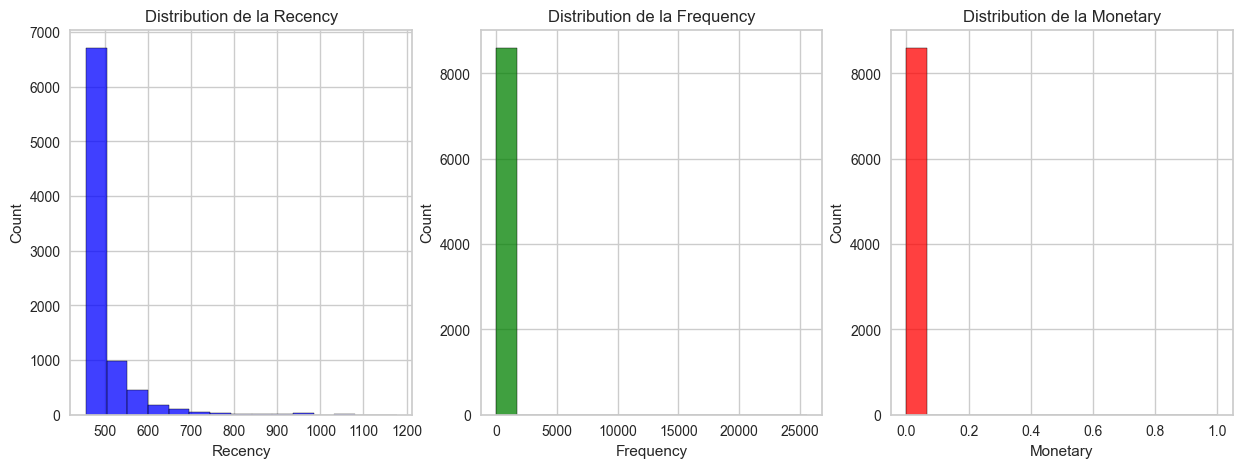

In [100]:
# On créé 3 histogrammes pour voir la distribution de chaque colonnes

figs, axs = plt.subplots(1,3, figsize=(15,5))

sns.histplot(
    rfm['Recency'],
    ax=axs[0],
    color='blue',
    bins="sturges",
)
axs[0].set_title('Distribution de la Recency')

sns.histplot(
    rfm['Frequency'],
    ax=axs[1],
    color='green',
    bins="sturges",
)
axs[1].set_title('Distribution de la Frequency')

sns.histplot(
    rfm['Monetary'],
    ax=axs[2],
    color='red',
    bins="sturges",
)
axs[2].set_title('Distribution de la Monetary')

plt.show()

In [77]:
scaler_std = StandardScaler()

In [78]:
X_scaled = scaler_std.fit_transform(rfm[rfm.columns[1:]])
X_scaled

array([[ 0.08125297, -0.11784419, -0.14791928],
       [-0.08695718, -0.06999945, -0.0086431 ],
       [ 1.88568907, -0.22948192, -0.21984089],
       ...,
       [-0.22458366, -0.0668098 ,  0.01757714],
       [-0.49983662, -0.0795684 ,  0.27364978],
       [-0.31633465, -0.10827524, -0.13400665]])

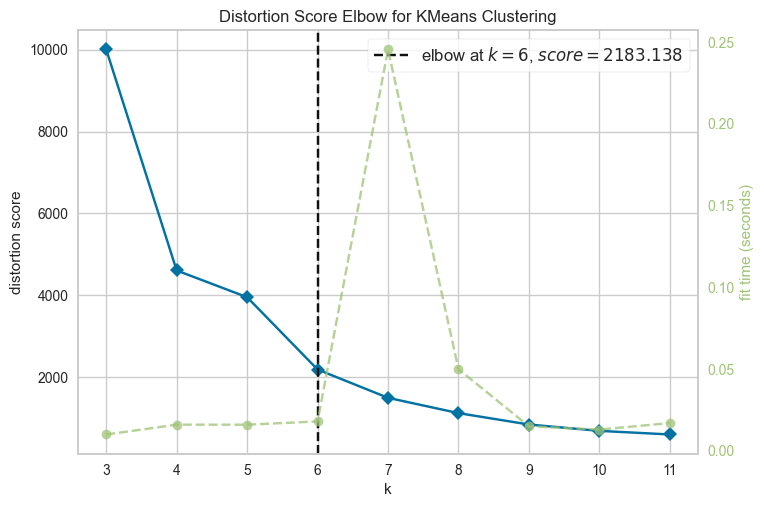

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [79]:
model = KMeans(n_init='auto', random_state=42)

visualiser = KElbowVisualizer(model, k=(3,12))

visualiser.fit(X_scaled)

visualiser.show()

In [80]:
# On divise le jeu de données en 6 clusters

kmeans = KMeans(n_clusters=6, n_init='auto', random_state=42)
kmeans.fit(X_scaled)

rfm['cluster'] = kmeans.labels_

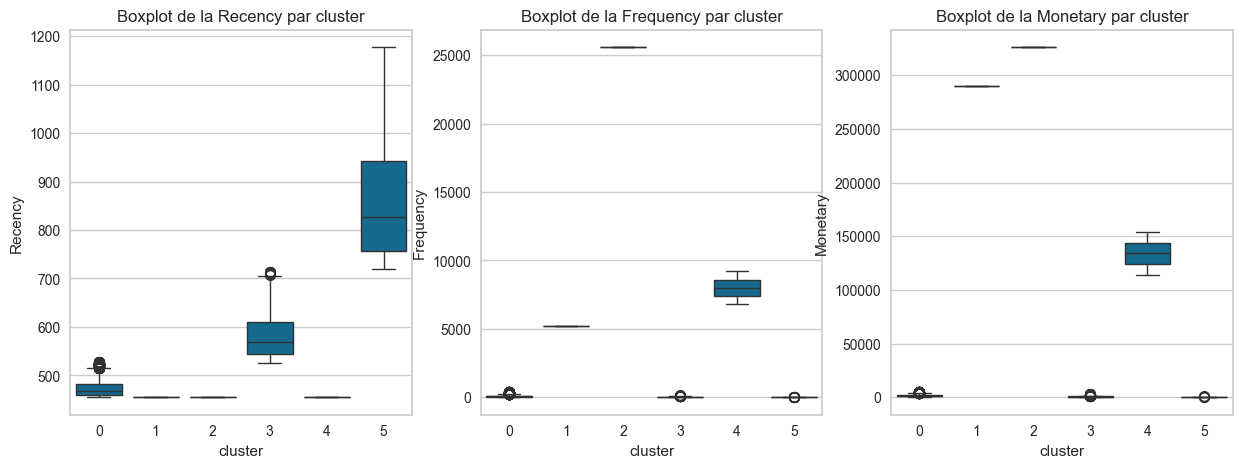

In [81]:
figs, axs = plt.subplots(1,3, figsize=(15,5))

sns.boxplot(
    x=rfm['cluster'],
    y=rfm['Recency'],
    ax=axs[0],
)
axs[0].set_title('Boxplot de la Recency par cluster')

sns.boxplot(
    x=rfm['cluster'],
    y=rfm['Frequency'],
    ax=axs[1],
)
axs[1].set_title('Boxplot de la Frequency par cluster')

sns.boxplot(
    x=rfm['cluster'],
    y=rfm['Monetary'],
    ax=axs[2],
)
axs[2].set_title('Boxplot de la Monetary par cluster')

plt.show()

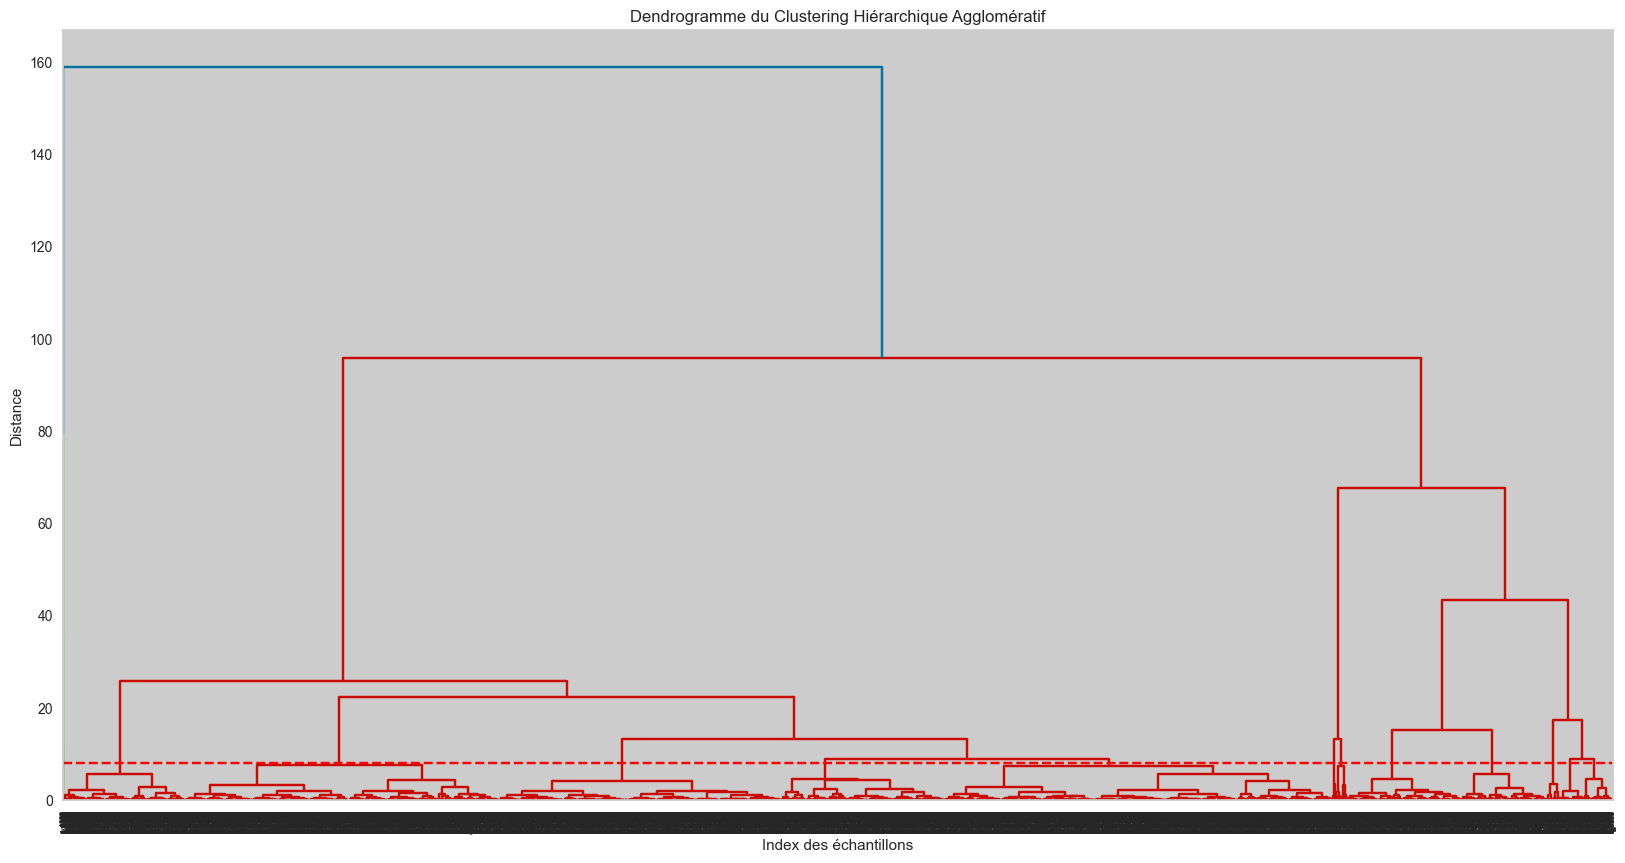

In [82]:
# Calculer la matrice de liaison

Z = linkage(X_scaled, method='ward')

# Afficher le dendrogramme

plt.figure(figsize=(20,10))
plt.title("Dendrogramme du Clustering Hiérarchique Agglomératif")
dendrogram(Z, labels=rfm.client_id.to_list())
plt.axhline(y=8,color='red',linestyle='--')
plt.xlabel('Index des échantillons')
plt.ylabel('Distance')
plt.show()

In [83]:
agg_clustering = AgglomerativeClustering(n_clusters=3)

agg_clustering.fit(X_scaled)

# On rajoute le numéro du cluster pour chaque client
rfm['cluster_agg'] = agg_clustering.labels_

rfm

,client_id,Recency,Frequency,Monetary,cluster,cluster_agg
0,c_1,499,43,629.02,0,2
1,c_10,488,58,1353.60,0,2
2,c_100,617,8,254.85,3,1
3,c_1000,490,126,2291.88,0,2
4,c_1001,460,103,1823.85,0,2
...,...,...,...,...,...,...
8595,c_995,554,14,189.41,3,1
8596,c_996,463,96,1637.34,0,2
8597,c_997,479,59,1490.01,0,2
8598,c_998,461,55,2822.22,0,2


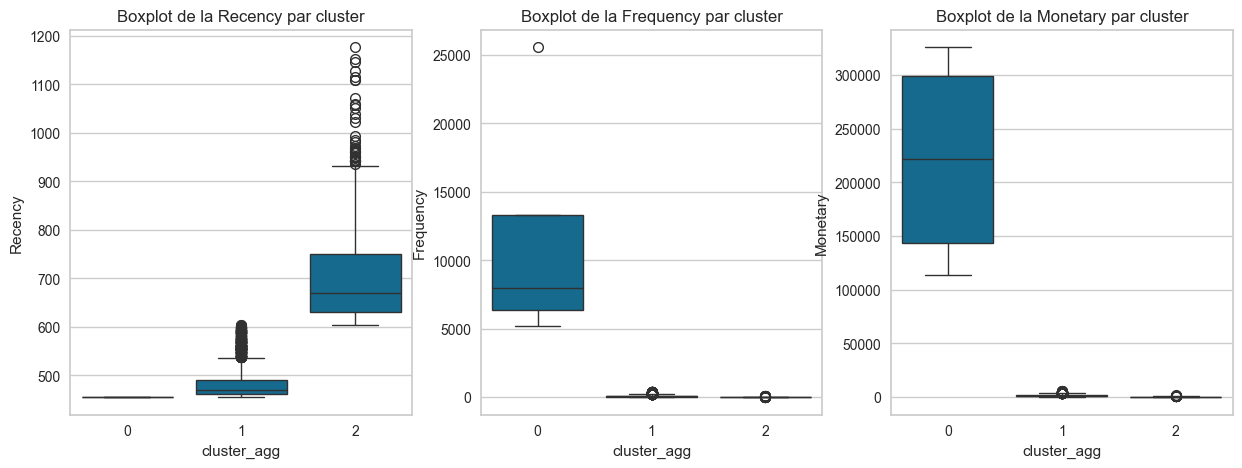

In [56]:
figs, axs = plt.subplots(1,3, figsize=(15,5))

sns.boxplot(
    x=rfm['cluster_agg'],
    y=rfm['Recency'],
    ax=axs[0],
)
axs[0].set_title('Boxplot de la Recency par cluster')

sns.boxplot(
    x=rfm['cluster_agg'],
    y=rfm['Frequency'],
    ax=axs[1],
)
axs[1].set_title('Boxplot de la Frequency par cluster')

sns.boxplot(
    x=rfm['cluster_agg'],
    y=rfm['Monetary'],
    ax=axs[2],
)
axs[2].set_title('Boxplot de la Monetary par cluster')

plt.show()

# Méthode 2

In [124]:
df_merge['date'] = pd.to_datetime(df_merge['date'], format='mixed', errors='coerce')

In [125]:
# Date la plus récente dans le dataset
max_date = df_merge['date'].max()

# Calcul de la récence
recency_df = df_merge.groupby('client_id').agg({'date': lambda x: (max_date - x.max()).days}).reset_index()
recency_df.columns = ['client_id', 'recency']

# Calcul de la fréquence
frequency_df = df_merge.groupby('client_id').agg({'date': 'count'}).reset_index()
frequency_df.columns = ['client_id', 'frequency']

# Calcul du montant
monetary_df = df_merge.groupby('client_id').agg({'price': 'sum'}).reset_index()
monetary_df.columns = ['client_id', 'monetary']

# Merge des dataframes
rfm_df = recency_df.merge(frequency_df, on='client_id').merge(monetary_df, on='client_id')

# Calcul des scores RFM
rfm_df['recency_score'] = pd.qcut(rfm_df['recency'], 5, labels=['5', '4', '3', '2', '1'])
rfm_df['frequency_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=['1', '2', '3', '4', '5'])
rfm_df['monetary_score'] = pd.qcut(rfm_df['monetary'], 5, labels=['1', '2', '3', '4', '5'])

# Score RFM global
rfm_df['RFM_Score'] = rfm_df['recency_score'].astype(str) + rfm_df['frequency_score'].astype(str) + rfm_df['monetary_score'].astype(str)

rfm_df.head()

,client_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score
0,c_1,44,43,629.02,2,3,2,232
1,c_10,32,58,1353.60,2,3,4,234
2,c_100,161,8,254.85,1,1,1,111
3,c_1000,35,126,2291.88,2,5,5,255
4,c_1001,5,103,1823.85,4,4,4,444


In [127]:
# Catégories préférées
category_df = df_merge.groupby(['client_id', 'id_prod']).agg({'price': 'sum'}).reset_index()
category_df = category_df.loc[category_df.groupby('client_id')['price'].idxmax()]
category_df = category_df[['client_id', 'id_prod']]
category_df.columns = ['client_id', 'favorite_category']

# Ajout de la catégorie préférée au DataFrame RFM
rfm_df = rfm_df.merge(category_df, on='client_id', how='left')

rfm_df.head()

,client_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,favorite_category
0,c_1,44,43,629.02,2,3,2,232,0_1448
1,c_10,32,58,1353.60,2,3,4,234,2_43
2,c_100,161,8,254.85,1,1,1,111,2_194
3,c_1000,35,126,2291.88,2,5,5,255,1_369
4,c_1001,5,103,1823.85,4,4,4,444,2_2


In [128]:
# Nombre moyen de transactions par mois
df_merge['month'] = df_merge['date'].dt.to_period('M')
monthly_transactions = df_merge.groupby(['client_id', 'month']).size().reset_index(name='transactions')
average_transactions = monthly_transactions.groupby('client_id')['transactions'].mean().reset_index()
average_transactions.columns = ['client_id', 'avg_transactions_per_month']

# Valeur moyenne des transactions
average_value = df_merge.groupby('client_id')['price'].mean().reset_index()
average_value.columns = ['client_id', 'avg_transaction_value']

# Ajout des nouvelles variables au DataFrame RFM
rfm_df = rfm_df.merge(average_transactions, on='client_id', how='left')
rfm_df = rfm_df.merge(average_value, on='client_id', how='left')

rfm_df.head()

,client_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,favorite_category,avg_transactions_per_month,avg_transaction_value
0,c_1,44,43,629.02,2,3,2,232,0_1448,2.529412,14.628372
1,c_10,32,58,1353.60,2,3,4,234,2_43,3.625000,23.337931
2,c_100,161,8,254.85,1,1,1,111,2_194,1.600000,31.856250
3,c_1000,35,126,2291.88,2,5,5,255,1_369,5.727273,18.189524
4,c_1001,5,103,1823.85,4,4,4,444,2_2,5.150000,17.707282


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Préparation des données (assurez-vous que toutes les colonnes sont numériques)
numeric_df = rfm_df.select_dtypes(include='number')
X = numeric_df
y = (rfm_df['RFM_Score'].apply(lambda x: int(x) > 444)).astype(int)  # Exemple de cible: score RFM élevé

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00       465

    accuracy                           1.00      1720
   macro avg       1.00      1.00      1.00      1720
weighted avg       1.00      1.00      1.00      1720

